# Sales Forecast System With Time Series

## Step 1: Import Libraries

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import statsmodels.api as sm
try:
    from pmdarima import auto_arima
except:
    auto_arima = None

try:
    from prophet import Prophet
except:
    try:
        from fbprophet import Prophet
    except:
        Prophet = None

from sklearn.ensemble import RandomForestRegressor


## Step 2: Data Import

In [17]:
DATA_PATH = 'train.csv'   # Update with your dataset path
SAMPLE_STORE = 1
SAMPLE_ITEM = 1
FORECAST_DAYS = 30
TEST_MONTHS = 3

print('Loading dataset...')
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
print('Shape:', df.shape)
print(df.head())

Loading dataset...
Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10


## Step 3: Data Exploration (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64
Unique stores: 10
Unique items: 50


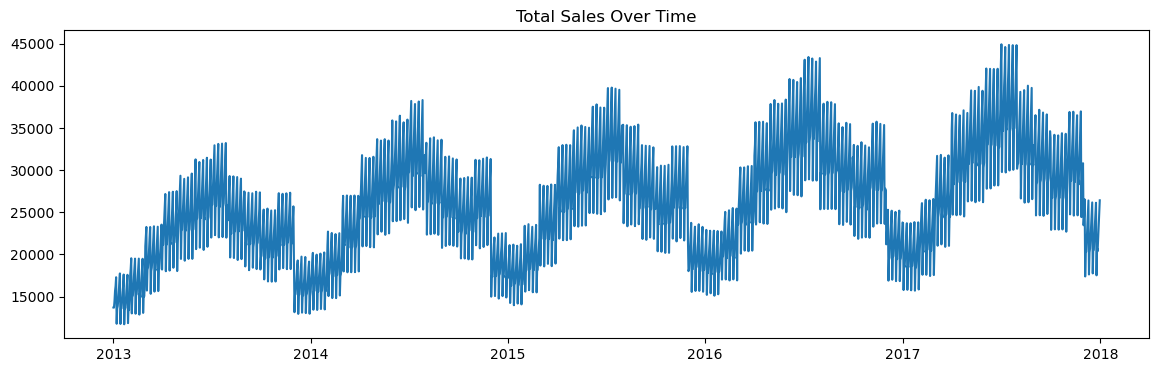

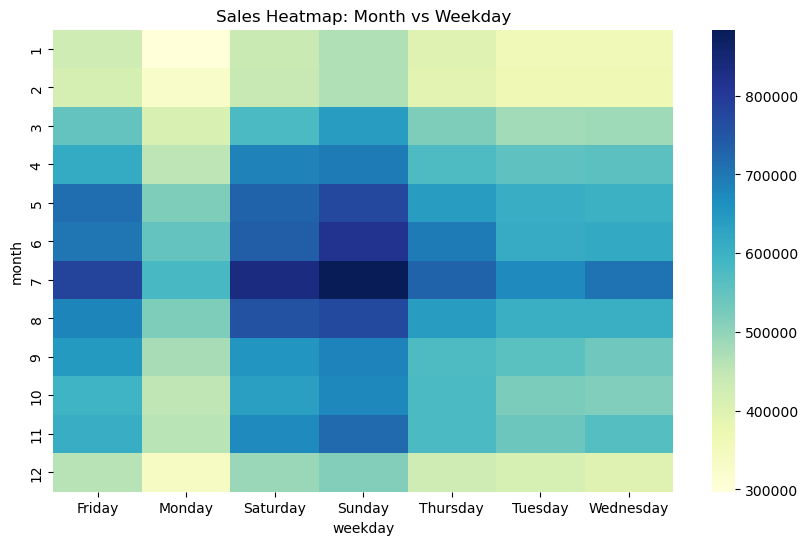

In [18]:
print(df.info())
print(df['sales'].describe())
print('Unique stores:', df['store'].nunique())
print('Unique items:', df['item'].nunique())

# Sales trend
daily_tot = df.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(14,4))
plt.plot(daily_tot['date'], daily_tot['sales'])
plt.title('Total Sales Over Time')
plt.show()

# Seasonality heatmap
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
agg = df.groupby(['month','weekday'])['sales'].sum().unstack().fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(agg, cmap='YlGnBu')
plt.title('Sales Heatmap: Month vs Weekday')
plt.show()

## Step 4: Data Preprocessing

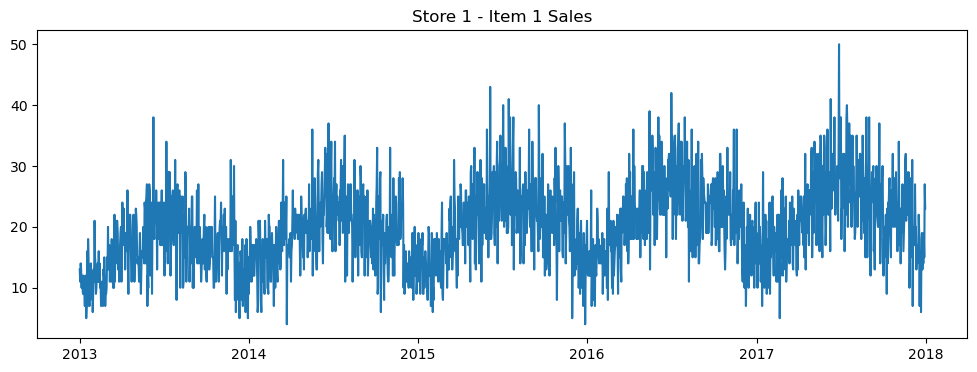

In [19]:
mask = (df['store']==SAMPLE_STORE) & (df['item']==SAMPLE_ITEM)
df_si = df.loc[mask,['date','sales']].set_index('date').asfreq('D')
df_si['sales'] = df_si['sales'].fillna(0)

plt.figure(figsize=(12,4))
plt.plot(df_si.index, df_si['sales'])
plt.title(f'Store {SAMPLE_STORE} - Item {SAMPLE_ITEM} Sales')
plt.show()

## Step 5: Feature Engineering

In [20]:
series = df_si.copy()
series['lag_1'] = series['sales'].shift(1)
series['lag_7'] = series['sales'].shift(7)
series['lag_30'] = series['sales'].shift(30)
series['roll_7'] = series['sales'].rolling(window=7).mean()
series['roll_30'] = series['sales'].rolling(window=30).mean()
series['day'] = series.index.day
series['month'] = series.index.month
series['weekday'] = series.index.weekday
series['weekofyear'] = series.index.isocalendar().week
series = series.dropna()

last_date = series.index.max()
train_cutoff = last_date - pd.DateOffset(months=TEST_MONTHS)
train = series[series.index <= train_cutoff]
test = series[series.index > train_cutoff]

print('Train:', train.shape, 'Test:', test.shape)

Train: (1704, 10) Test: (92, 10)


## Step 6a: Modeling with Prophet

14:46:28 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 3.833010976426899
Prophet RMSE: 4.633693143810757


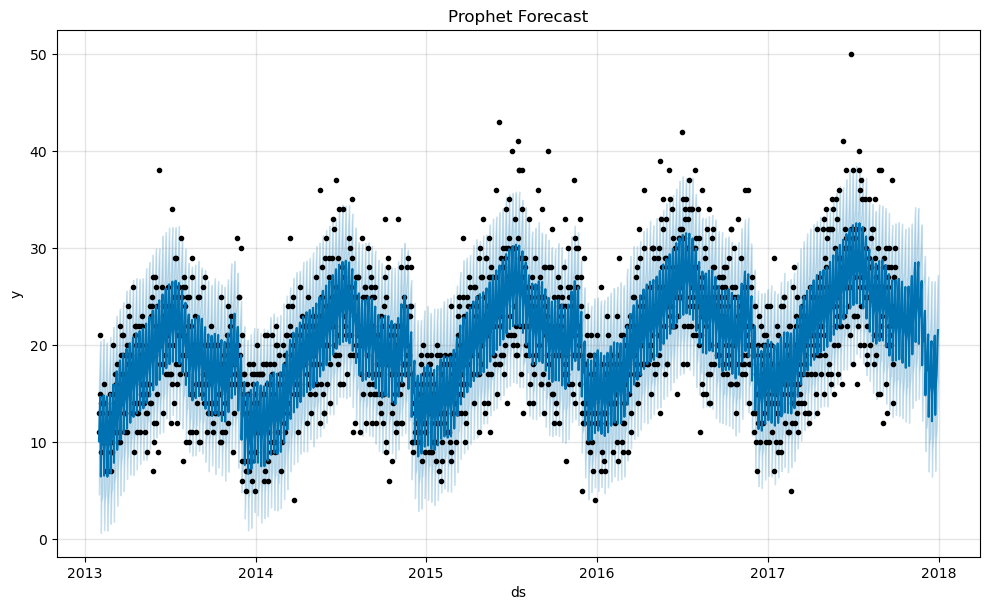

In [21]:
if Prophet is not None:
    prophet_df = series[['sales']].reset_index().rename(columns={'date':'ds','sales':'y'})
    prop_train = prophet_df[prophet_df['ds'] <= train_cutoff]
    prop_test = prophet_df[prophet_df['ds'] > train_cutoff]

    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(prop_train)

    future = m.make_future_dataframe(periods=len(prop_test), freq='D')
    forecast = m.predict(future)

    pred = forecast.set_index('ds').loc[prop_test['ds'],'yhat']
    y_true = prop_test['y'].values

    print('Prophet MAE:', mean_absolute_error(y_true,pred))
    print('Prophet RMSE:', sqrt(mean_squared_error(y_true,pred)))

    m.plot(forecast)
    plt.title('Prophet Forecast')
    plt.show()

## Step 6b: Modeling with ARIMA

=== ARIMA Evaluation ===
RMSE: 7.81
MAE : 6.48


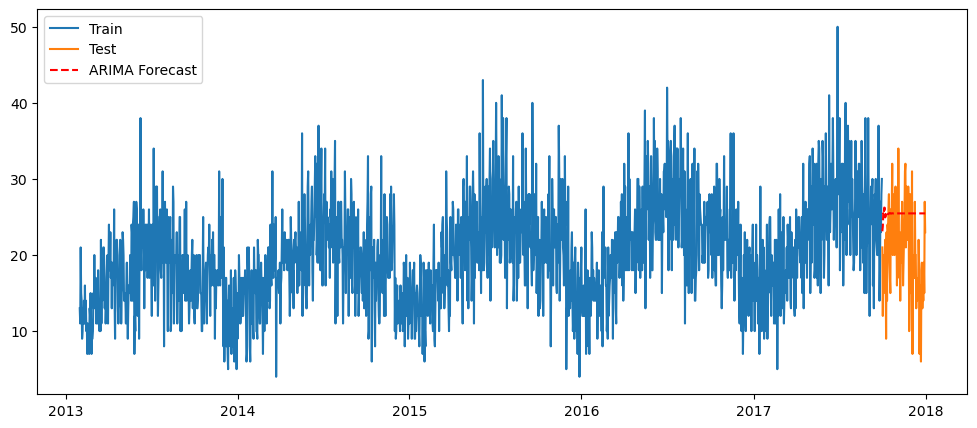

In [22]:
# Step 6b: Modeling with ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit ARIMA model (example order, tune as needed)
model = ARIMA(train['sales'], order=(5,1,0))
arima_result = model.fit()

# Predict on test set
arima_forecast = arima_result.forecast(steps=len(test))

# Evaluate
rmse = mean_squared_error(test['sales'], arima_forecast, squared=False)
mae = mean_absolute_error(test['sales'], arima_forecast)

print("=== ARIMA Evaluation ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

# Plot results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='red')
plt.legend()
plt.show()


## Step 6c: Modeling with Random Forest (Baseline)

RF MAE: 3.5626086956521745
RF RMSE: 4.3254786113667585


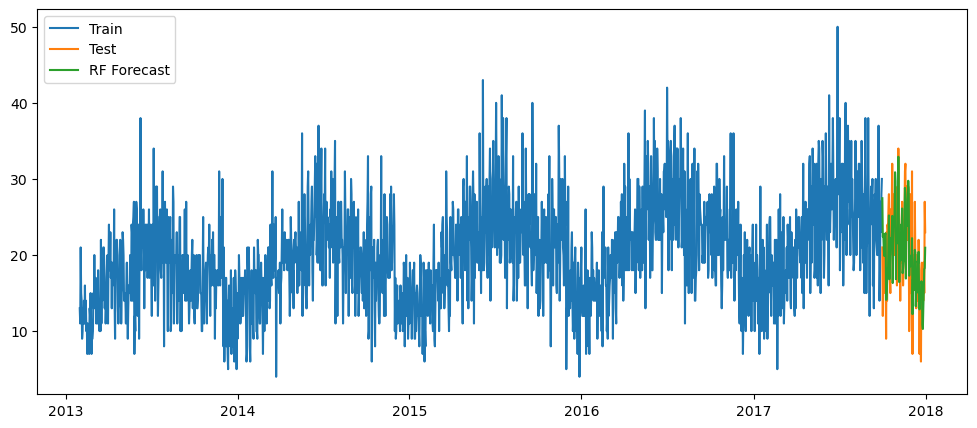

In [23]:
feature_cols = ['lag_1','lag_7','lag_30','roll_7','roll_30','day','month','weekday']
X_train, y_train = train[feature_cols], train['sales']
X_test, y_test = test[feature_cols], test['sales']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print('RF MAE:', mean_absolute_error(y_test, rf_pred))
print('RF RMSE:', sqrt(mean_squared_error(y_test, rf_pred)))

plt.figure(figsize=(12,5))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test')
plt.plot(test.index, rf_pred, label='RF Forecast')
plt.legend()
plt.show()

## Step 7 & 8: Forecast Next 30 Days

14:51:19 - cmdstanpy - INFO - Chain [1] start processing
14:51:19 - cmdstanpy - INFO - Chain [1] done processing


[12.82848028 15.56262483 16.18723811 16.82614528 18.41675774 20.36329071
 21.15435611 12.78998714 15.43399305 15.97997386 16.55394807 18.09502872
 20.00860817 20.78393349 12.42112876 15.08356304 15.66389267 16.28673011
 17.88937342 19.87505483 20.73058844 12.45347121 15.20433356 15.87306593
 16.58157119 18.26457438 20.32294628 21.24141867 13.01574364 15.80519179]


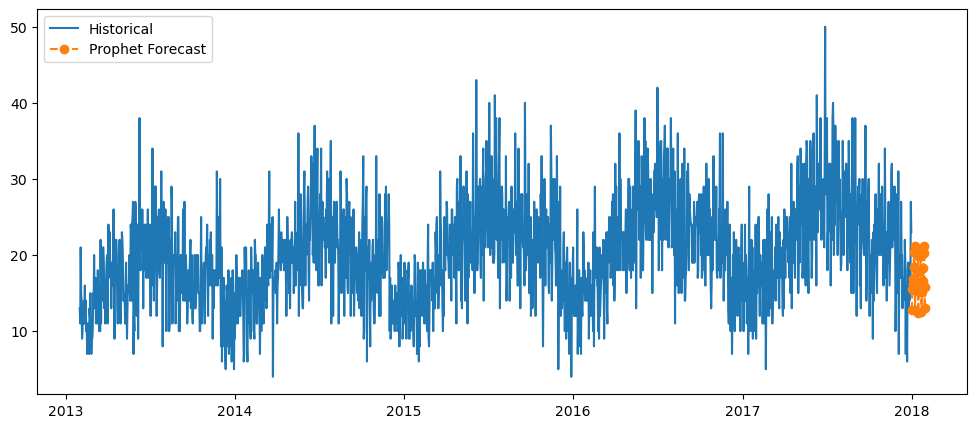

In [25]:
if Prophet is not None:
    m_full = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    df_prop_full = series[['sales']].reset_index().rename(columns={'date':'ds','sales':'y'})
    m_full.fit(df_prop_full)
    future_30 = m_full.make_future_dataframe(periods=FORECAST_DAYS, freq='D')
    forecast_30 = m_full.predict(future_30)

    forecast_out = forecast_30.set_index('ds').loc[series.index.max()+pd.Timedelta(days=1):,'yhat']
    print(forecast_out.values)

    plt.figure(figsize=(12,5))
    plt.plot(series.index, series['sales'], label='Historical')
    plt.plot(forecast_out.index, forecast_out.values, '--', marker='o', label='Prophet Forecast')
    plt.legend()
    plt.show()

## Step 9: Final Output & Conclusion

14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing


Predicted next 7 days sales for Store 1, Item 1:
[13, 16, 16, 17, 18, 20, 21]


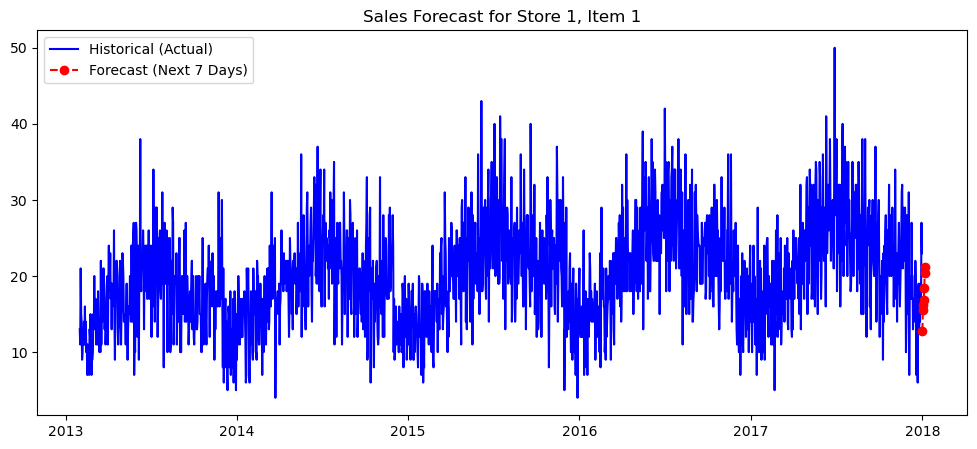


Project Conclusion:    
We successfully built time series forecasting models (ARIMA, Prophet).
Prophet was finally used to predict the next 7 days of demand.
This helps stores plan inventory better, reducing overstocking/understocking.


In [28]:
# Step 9: Sample Output (Final Step)

# Forecast next 7 days using Prophet (you can switch to ARIMA if you prefer)
FORECAST_DAYS = 7  

if Prophet is not None:
    m_final = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    df_final = series[['sales']].reset_index().rename(columns={'date':'ds','sales':'y'})
    m_final.fit(df_final)

    future_final = m_final.make_future_dataframe(periods=FORECAST_DAYS, freq='D')
    forecast_final = m_final.predict(future_final)

    # Extract the forecast for next 7 days
    forecast_next7 = forecast_final[['ds','yhat']].tail(FORECAST_DAYS)
    predicted_sales = forecast_next7['yhat'].round().astype(int).tolist()

    print(f"Predicted next {FORECAST_DAYS} days sales for Store {SAMPLE_STORE}, Item {SAMPLE_ITEM}:")
    print(predicted_sales)

    # Plot historical vs forecast
    plt.figure(figsize=(12,5))
    plt.plot(series.index, series['sales'], label='Historical (Actual)', color='blue')
    plt.plot(forecast_next7['ds'], forecast_next7['yhat'], '--o', color='red', label='Forecast (Next 7 Days)')
    plt.legend()
    plt.title(f"Sales Forecast for Store {SAMPLE_STORE}, Item {SAMPLE_ITEM}")
    plt.show()

# Project Conclusion
print("\nProject Conclusion:    ")
print("We successfully built time series forecasting models (ARIMA, Prophet).")
print("Prophet was finally used to predict the next 7 days of demand.")
print("This helps stores plan inventory better, reducing overstocking/understocking.")

## Step 10: Export Forecast to CSV

In [29]:
# Step 10: Export Forecast Results to CSV

# Save the next 30-day forecast (or 7-day, adjust FORECAST_DAYS as needed)
FORECAST_DAYS = 30  

if Prophet is not None:
    # Refit full model and generate forecast
    m_export = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    df_export = series[['sales']].reset_index().rename(columns={'date':'ds','sales':'y'})
    m_export.fit(df_export)

    future_export = m_export.make_future_dataframe(periods=FORECAST_DAYS, freq='D')
    forecast_export = m_export.predict(future_export)

    # Keep only the last forecast period
    forecast_output = forecast_export[['ds','yhat','yhat_lower','yhat_upper']].tail(FORECAST_DAYS)
    forecast_output['store'] = SAMPLE_STORE
    forecast_output['item'] = SAMPLE_ITEM

    # Save to CSV
    output_file = f"forecast_store{SAMPLE_STORE}_item{SAMPLE_ITEM}.csv"
    forecast_output.to_csv(output_file, index=False)

    print(f"Forecast for next {FORECAST_DAYS} days saved to: {output_file}")
    display(forecast_output.head())  # show first few rows

14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing


Forecast for next 30 days saved to: forecast_store1_item1.csv


,ds,yhat,yhat_lower,yhat_upper,store,item
1796,2018-01-01,12.828480,7.082923,18.785026,1,1
1797,2018-01-02,15.562625,9.919926,21.343037,1,1
1798,2018-01-03,16.187238,10.600907,21.628356,1,1
1799,2018-01-04,16.826145,11.167055,22.478786,1,1
1800,2018-01-05,18.416758,12.743270,24.188038,1,1
